### Signate Jリーグ
https://signate.jp/competitions/27

In [1]:
##　import文
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy.stats as stats
import pylab
% matplotlib inline

In [2]:
## trainデータの情報表示
df_train = pd.read_csv('train_new.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1953 entries, 0 to 1952
Data columns (total 43 columns):
id             1953 non-null int64
y              1953 non-null int64
year           1953 non-null int64
stage          1953 non-null object
match          1953 non-null object
gameday        1953 non-null object
time           1953 non-null object
home           1953 non-null object
away           1953 non-null object
stadium        1953 non-null object
tv             1953 non-null object
home_score     1953 non-null int64
away_score     1953 non-null int64
weather        1953 non-null object
temperature    1953 non-null float64
humidity       1953 non-null object
referee        1953 non-null object
home_team      1953 non-null object
home_01        1953 non-null object
home_02        1953 non-null object
home_03        1953 non-null object
home_04        1953 non-null object
home_05        1953 non-null object
home_06        1953 non-null object
home_07        1953 non-null obje

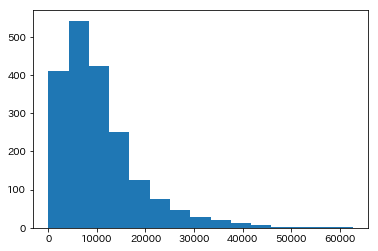

In [3]:
#目的変数のヒストグラム表示
plt.hist(df_train['y'], bins=15)
plt.show()

### 対数変換
目的変数の分布が線形回帰が仮定している正規分布ではない。

目的変数が正規分布に従わない→被説明変数を対数変換し、正規分布ライクな形に整形し直し、線形回帰を実施。

In [4]:
y = df_train['y'].values
df_train['logy'] = np.log(y)

/Users/RyoYasumori/.pyenv/versions/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


logの計算ができないことで出るWarningということでdf_train.to_csv('../confirmation.csv')で確認してみると  
1569番目のデータのyに0が含まれていることが分かるのでそのデータを例外として削除する。

In [5]:
logy = df_train['logy'].values
df_train['loglogy'] = np.log(logy)
df_train=df_train.dropna(subset=['loglogy'])

/Users/RyoYasumori/.pyenv/versions/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


nullを確認

In [6]:
df_train.isnull().sum()

id             0
y              0
year           0
stage          0
match          0
gameday        0
time           0
home           0
away           0
stadium        0
tv             0
home_score     0
away_score     0
weather        0
temperature    0
humidity       0
referee        0
home_team      0
home_01        0
home_02        0
home_03        0
home_04        0
home_05        0
home_06        0
home_07        0
home_08        0
home_09        0
home_10        0
home_11        0
away_team      0
away_01        0
away_02        0
away_03        0
away_04        0
away_05        0
away_06        0
away_07        0
away_08        0
away_09        0
away_10        0
away_11        0
address        0
capa           0
logy           0
loglogy        0
dtype: int64

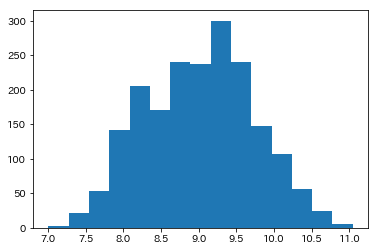

In [7]:
plt.hist(df_train['logy'], bins=15)
plt.show()

正規分布に近づけることができたと考えられるが、QQプロットとシャピロウィルク検定を用いて再確認する。

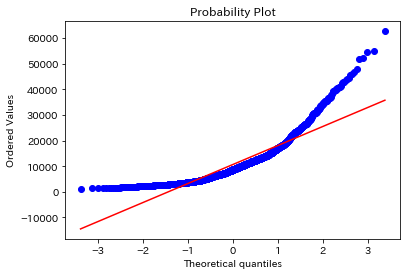

In [8]:
## QQプロット
stats.probplot(df_train['y'], dist="norm", plot=pylab)
plt.show()

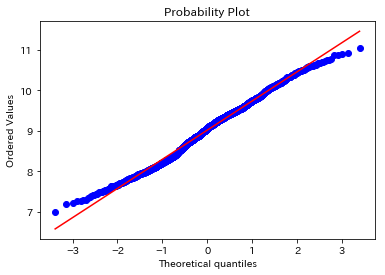

In [9]:
stats.probplot(df_train['logy'], dist="norm", plot=pylab)
plt.show()

In [10]:
##シャピロウィルク検定
b = stats.shapiro(df_train['y'])
print("対数変換前: ")
print(b)
print("")
a = stats.shapiro(df_train['logy'])
print("対数変換後: ")
print(a)

対数変換前: 
(0.8354302644729614, 6.124234808485181e-41)

対数変換後: 
(0.9928132891654968, 3.526571745737783e-08)


正確な正規分布にならないようであるが、正規分布には近づいている。

In [11]:
#試合時期
df_train['match_section'] = df_train['match'].apply(lambda x: int(x[1:].split('節')[0]))
df_train['match_day'] = df_train['match'].apply(lambda x: int(x[:-1].rsplit('第', 1)[-1]))

In [12]:
#試合月、曜日、休日かどうか、開始時刻
df_train['game_month'] = df_train['gameday'].apply(lambda x: int(x.split('/')[0]))
df_train['game_day'] = df_train['gameday'].apply(lambda x: x[:-1].rsplit('(', 1)[-1])
df_train['is_holiday'] = df_train['game_day'].apply(lambda x: 1 if (x.count('土') + x.count('日') + x.count('祝') + x.count('休')) else 0)
df_train['game_time'] = df_train['time'].apply(lambda x: int(x.split(':')[0]))

In [13]:
#地上波で無料放映されているか
df_train['free_watching'] = df_train['tv'].apply(lambda x:1 if any([not z.count('ＢＳ') and
                                                              not z.count('スカパー') and
                                                              not z.count('ｅ２') for z in x.split('／')]) else 0)

In [14]:
#天気
df_train['is_rain'] = df_train['weather'].apply(lambda x: 1 if x.count('雨') else 0)

#湿度
df_train['humid'] = df_train['humidity'].apply(lambda x: int(x.split('%')[0]))

df_train['thi'] = 0.81*df_train['temperature']+0.01*df_train['humid']*(0.99*df_train['temperature']-14.3)+46.3

In [15]:
#県
df_train['prefecture'] = df_train['address'].apply(lambda x: re.split(r'都|道|府|県', x)[0])


In [16]:
## 'temperature', 'humid', 'thi', 'capa', 'y'　に絞って頭5つのデータを表示
df_value = df_train.loc[:, ['temperature', 'humid', 'thi', 'capa', 'logy']]
df_value.head()

,temperature,humid,thi,capa,logy
0,3.8,66,42.42292,19694,9.811920
1,12.4,43,55.47368,40000,10.098890
2,11.3,41,54.17667,21000,9.744843
3,11.4,52,53.96672,50000,10.295631
4,22.5,32,67.07700,39232,10.140652


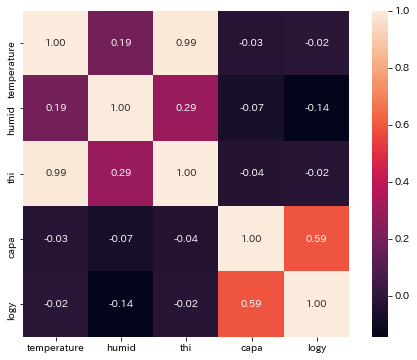

In [17]:
## ヒートマップ表示
plt.figure(figsize=(8, 6))
sns.heatmap(df_value.corr(), annot=True, square=True, fmt='.2f')
plt.show()

/Users/RyoYasumori/.pyenv/versions/3.6.3/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


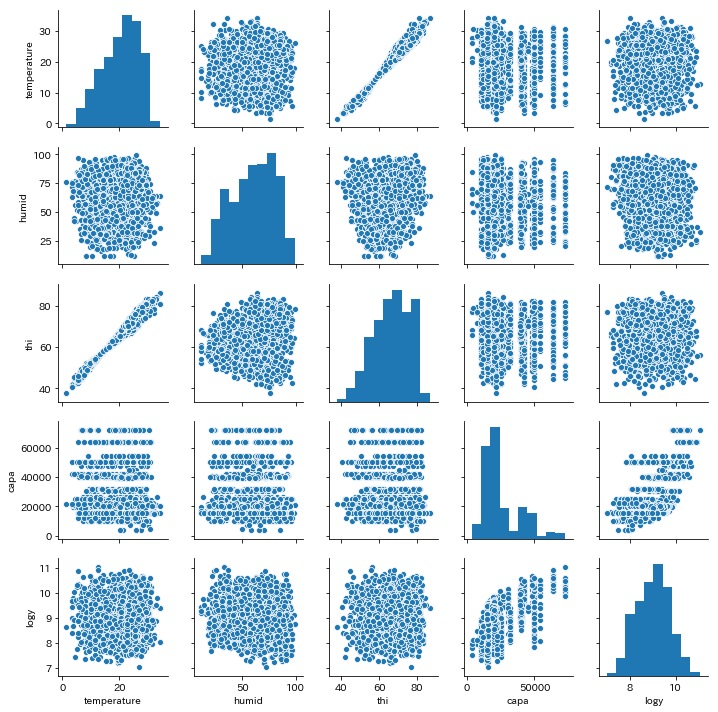

In [18]:
## 散布図行列の表示
sns.pairplot(df_value, size=2.0)
plt.show()

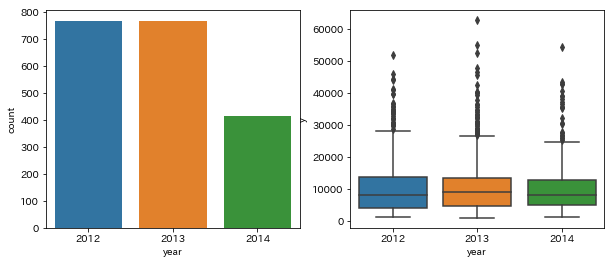

In [19]:
#yearは特に影響がなさそう
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.countplot(df_train['year'])
plt.subplot(1, 2, 2)
sns.boxplot(x='year', y='y' , data=df_train)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

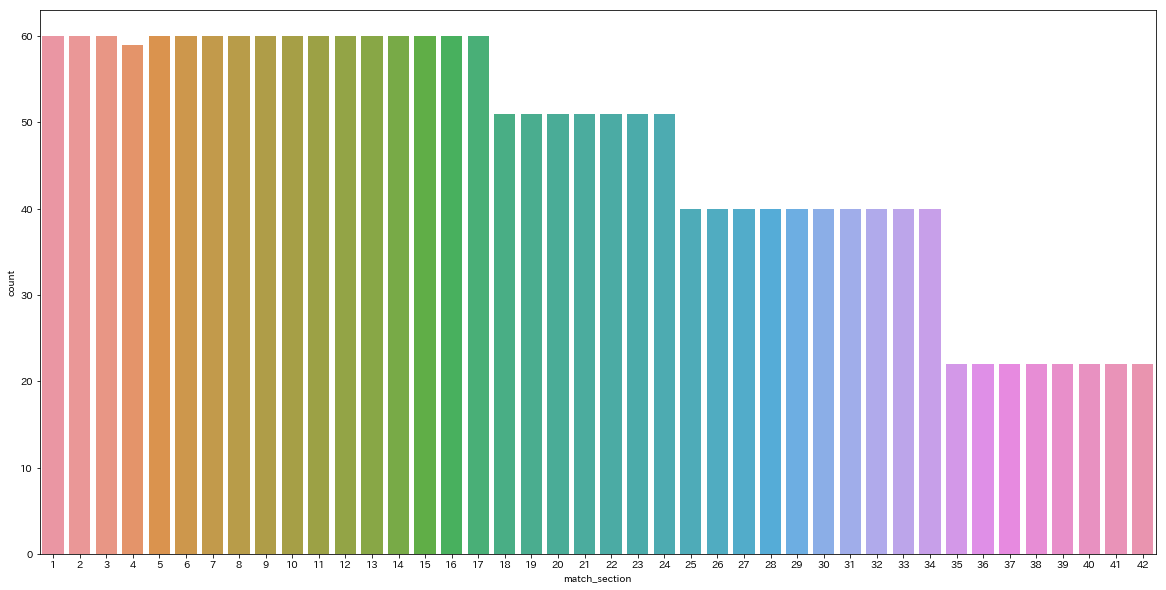

In [20]:
plt.figure(figsize=(20, 10))
sns.countplot(df_train['match_section'])
plt.show

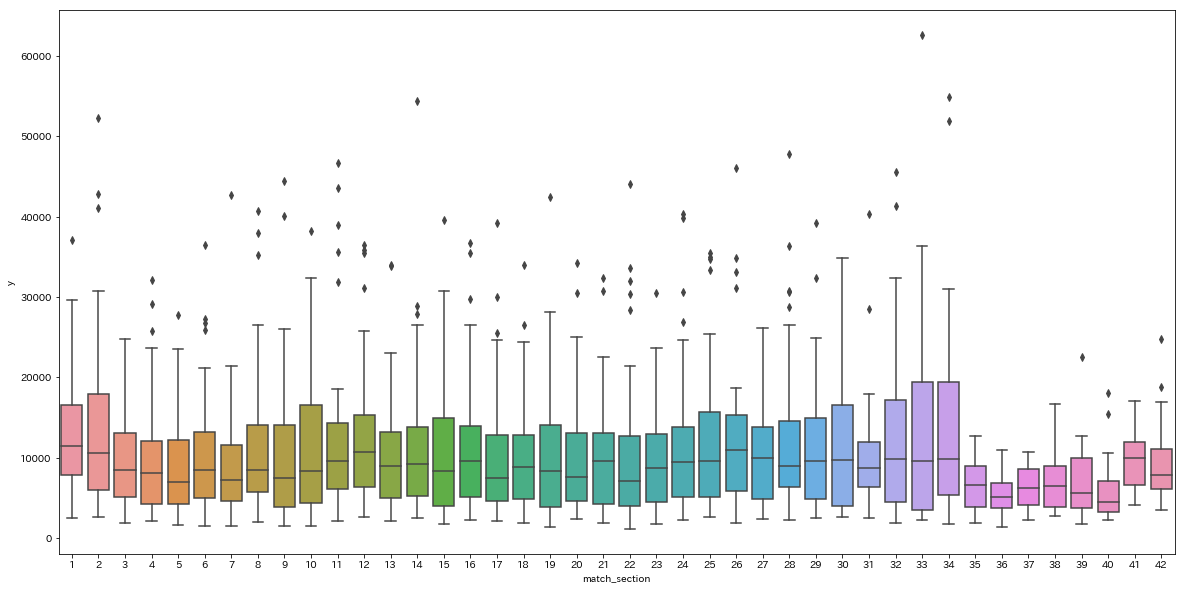

In [21]:
#試合節は使えそう
plt.figure(figsize=(20, 10))
sns.boxplot(x='match_section', y='y' , data=df_train)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

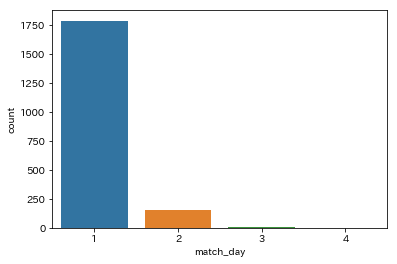

In [22]:
#日はデータ量が異なるため使えなそう
plt.figure(figsize=(6, 4))
sns.countplot(df_train['match_day'])
plt.show

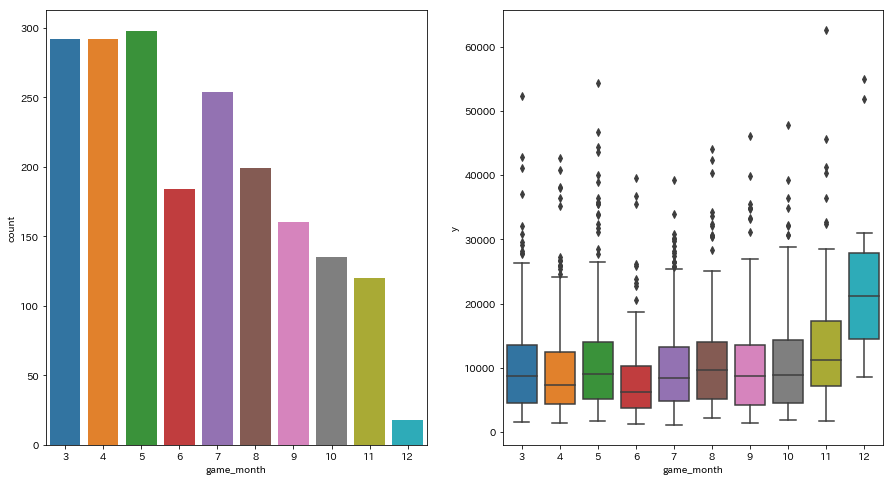

In [23]:
#12月はデータ量が少ないが観客動員数は多い

plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
sns.countplot(df_train['game_month'])

plt.subplot(1, 2, 2)
sns.boxplot(x='game_month', y='y' , data=df_train)
plt.show()

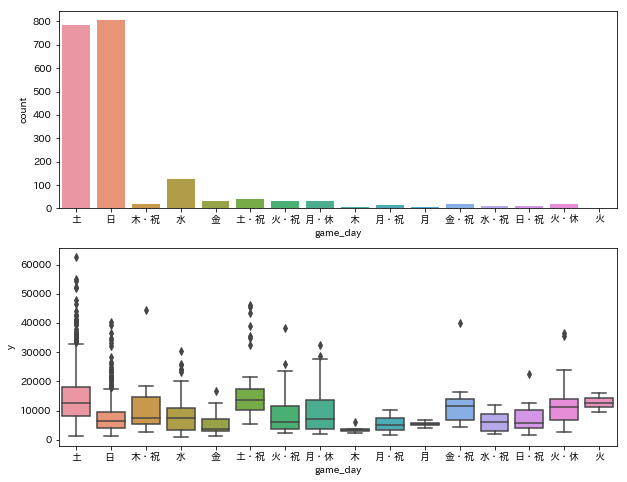

In [24]:
#試合が土日に固まっているのでデータ量にばらつきがある。土日のみを比べる（土曜の方が動員数多い）
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
sns.countplot(df_train['game_day'])

plt.subplot(2, 1, 2)
sns.boxplot(x='game_day', y='y' , data=df_train)
plt.show()

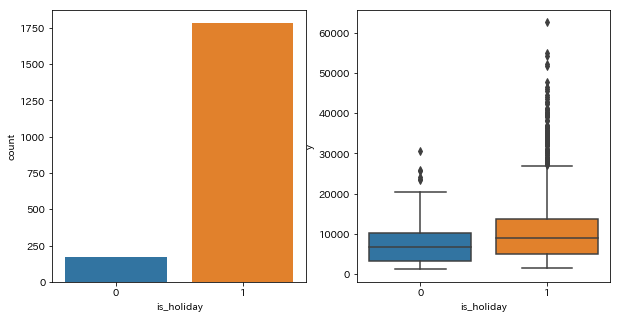

In [25]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(df_train['is_holiday'])

plt.subplot(1, 2, 2)
sns.boxplot(x='is_holiday', y='y', data=df_train)
plt.show()

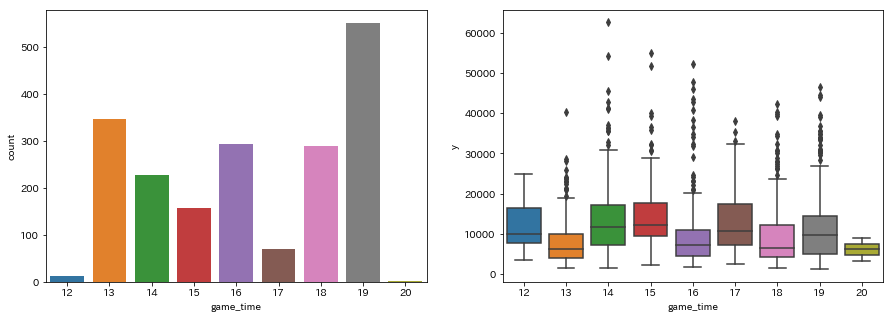

In [26]:
#開始時刻によってばらつきがある。
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.countplot(df_train['game_time'])
plt.subplot(1, 2, 2)
sns.boxplot(x='game_time', y='y', data=df_train)
plt.show()

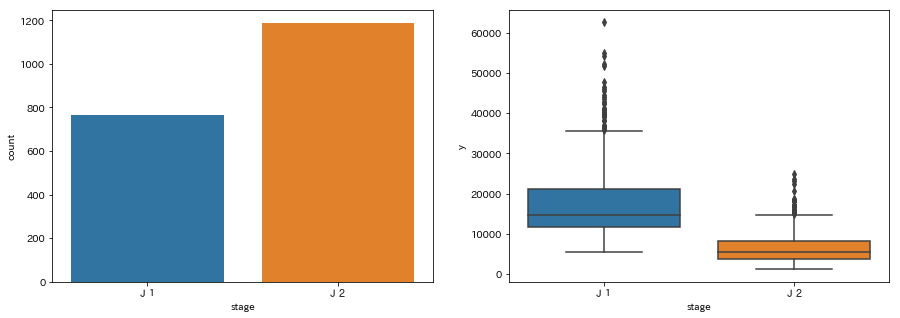

In [27]:
#J1が多いのは明らか
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.countplot(df_train['stage'])
plt.subplot(1, 2, 2)
sns.boxplot(x='stage', y='y', data=df_train)

plt.figure(figsize=(10, 15))
plt.subplot(2, 1, 1)
sns.countplot(df_train['home'])
plt.xticks(rotation=90)
plt.subplot(2, 1, 2)
sns.boxplot(x='home', y='y' , data=df_train)
plt.xticks(rotation=90)
plt.show()

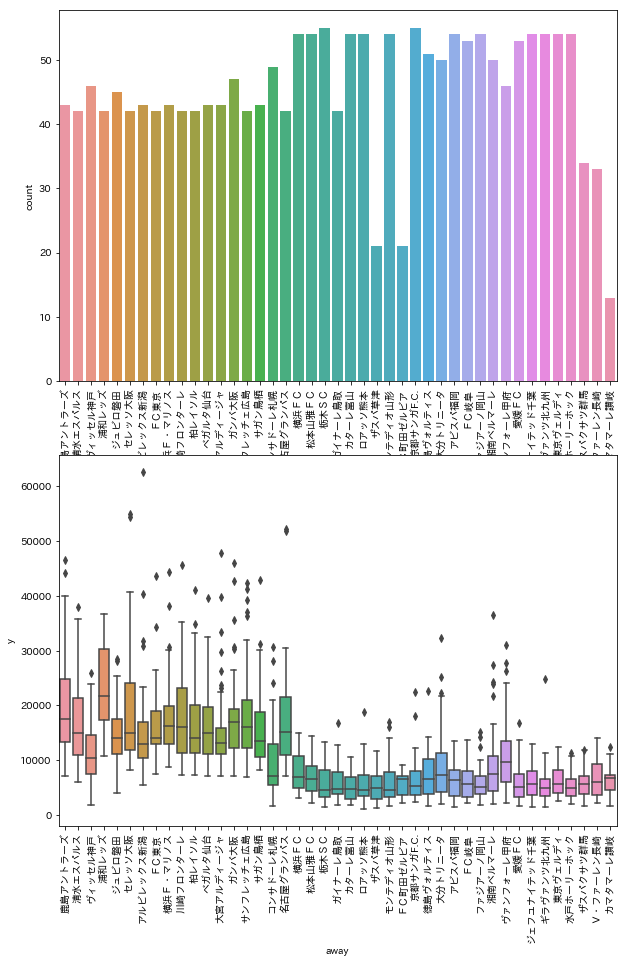

In [28]:
#浦和レッズ
plt.figure(figsize=(10, 15))
plt.subplot(2, 1, 1)
sns.countplot(df_train['away'])
plt.xticks(rotation=90)

plt.subplot(2, 1, 2)
sns.boxplot(x='away', y='y' , data=df_train)
plt.xticks(rotation=90)
plt.show()

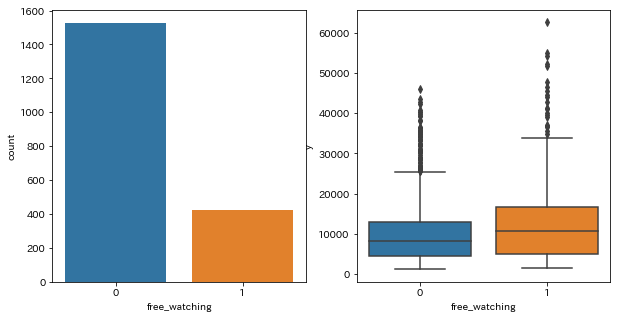

In [29]:
#無料で放映されたものほど観客動員数が多い

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(df_train['free_watching'])

plt.subplot(1, 2, 2)
sns.boxplot(x='free_watching', y='y', data=df_train)
plt.show()

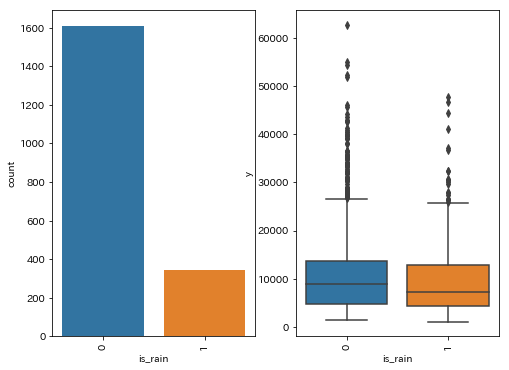

In [30]:
#天気が雨の時は若干少ない
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
sns.countplot(df_train['is_rain'])
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.boxplot(x='is_rain', y='y', data=df_train)
plt.xticks(rotation=90)
plt.show()

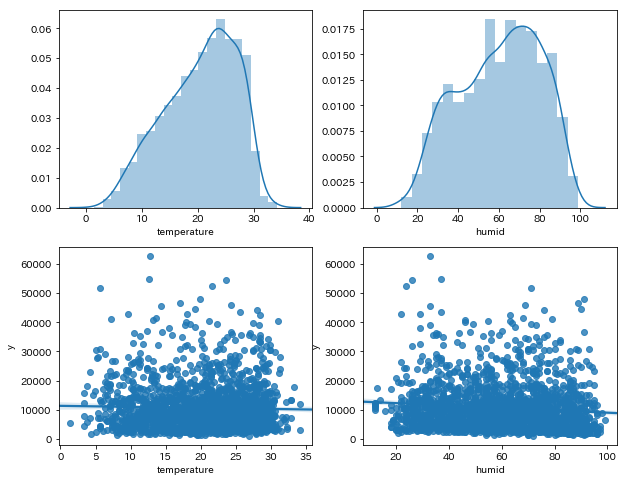

In [31]:
#共に関係なさそう

plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
sns.distplot(df_train['temperature'])

plt.subplot(2, 2, 2)
sns.distplot(df_train['humid'])

plt.subplot(2, 2, 3)
sns.regplot(x='temperature', y='y', data=df_train)

plt.subplot(2, 2, 4)
sns.regplot(x='humid', y='y', data=df_train)

plt.show()

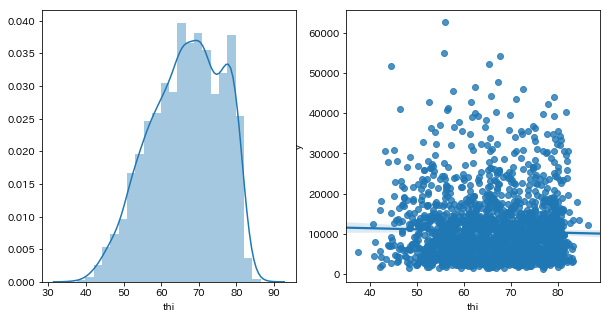

In [32]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.distplot(df_train['thi'])

plt.subplot(1, 2, 2)
sns.regplot(x='thi', y='y', data=df_train)

plt.show()

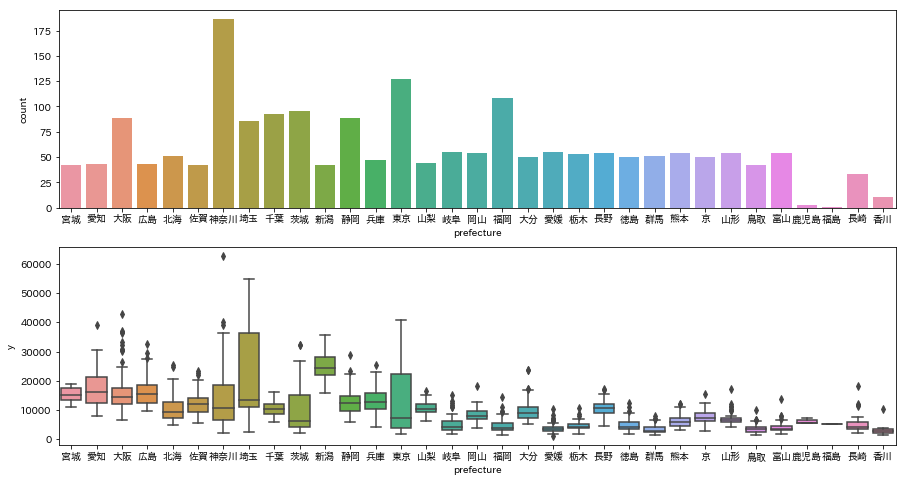

In [33]:
#saitama

plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
sns.countplot(df_train['prefecture'])

plt.subplot(2, 1, 2)
sns.boxplot(x='prefecture', y='y', data=df_train)
plt.show()

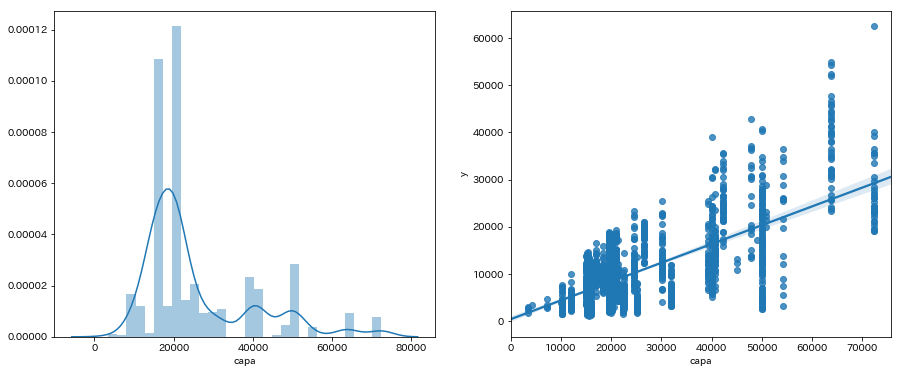

In [34]:
#収容数と観客数には間違いなく相関がある。
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.distplot(df_train['capa'])

plt.subplot(1, 2, 2)
sns.regplot(x='capa', y='y', data=df_train)
plt.show()

In [35]:
df_pickup = df_train.loc[:, ['match_section', 'game_month', 'is_holiday', 'game_time', 'free_watching', 'is_rain', 'capa']]
df_category = pd.get_dummies(df_train.loc[:, ['stage', 'game_day', 'home', 'away', 'prefecture']])
df_all = pd.concat([df_pickup, df_category], axis=1)
df_pickup.head()

,match_section,game_month,is_holiday,game_time,free_watching,is_rain,capa
0,1,3,1,14,1,1,19694
1,1,3,1,14,1,0,40000
2,1,3,1,14,1,1,21000
3,1,3,1,14,1,1,50000
4,1,3,1,14,1,0,39232


In [36]:
from sklearn.model_selection import train_test_split
X = df_all.values
y = df_train['logy'].values

In [37]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error as mse
train_rmse=0
val_rmse=0

for i in range(10):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
    mod = xgb.XGBRegressor()
    mod.fit(X_train, y_train)
    train_rmse += (mse(y_train, mod.predict(X_train)) ** (1/2))
    val_rmse += (mse(y_val, mod.predict(X_val)) ** (1/2))

train_rmse /= 10
val_rmse /= 10
    
# MSEを出力する関数を読み込む
print('RMSE')
print('train: %.3f' % train_rmse)
print('val : %.3f' % val_rmse)

ModuleNotFoundError: No module named 'xgboost'

In [41]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse
train_rmse=0
val_rmse=0

for i in range(10):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
    mod = GradientBoostingRegressor()
    mod.fit(X_train, y_train)
    train_rmse += (mse(y_train, mod.predict(X_train)) ** (1/2))
    val_rmse += (mse(y_val, mod.predict(X_val)) ** (1/2))

train_rmse /= 10
val_rmse /= 10
    
# MSEを出力する関数を読み込む
print('RMSE')
print('train: %.3f' % train_rmse)
print('val : %.3f' % val_rmse)

RMSE
train: 0.255
val : 0.297


In [42]:
from sklearn.ensemble import RandomForestRegressor
mod = RandomForestRegressor()
train_rmse=0
val_rmse=0

for i in range(10):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
    mod.fit(X_train, y_train)
    train_rmse += (mse(y_train, mod.predict(X_train)) ** (1/2))
    val_rmse += (mse(y_val, mod.predict(X_val)) ** (1/2))

train_rmse /= 10
val_rmse /= 10
    
# MSEを出力する関数を読み込む
print('RMSE')
print('train: %.3f' % train_rmse)
print('val : %.3f' % val_rmse)

RMSE
train: 0.123
val : 0.301


RandomForestは過学習している。

In [43]:
X_J1 = df_all[df_all['stage_Ｊ１'] == 1].values
y_J1 = df_train[df_train['stage'] == 'Ｊ１']['logy'].values
n_J1 = len(X_J1)
X_J2 = df_all[df_all['stage_Ｊ２'] == 1].values
y_J2 = df_train[df_train['stage'] == 'Ｊ２']['logy'].values
n_J2 = len(X_J2)
df_train[df_train['stage'] == 'Ｊ２']

,id,y,year,stage,match,gameday,time,home,away,stadium,...,match_day,game_month,game_day,is_holiday,game_time,free_watching,is_rain,humid,thi,prefecture
306,14300,5817,2012,Ｊ２,第１節第１日,03/04(日),13:05,水戸ホーリーホック,横浜ＦＣ,ケーズデンキスタジアム水戸,...,1,3,日,1,13,0,0,53,48.59778,茨城
307,14301,12432,2012,Ｊ２,第１節第１日,03/04(日),13:05,東京ヴェルディ,松本山雅ＦＣ,味の素スタジアム,...,1,3,日,1,13,0,0,49,48.87674,東京
308,14302,10169,2012,Ｊ２,第１節第１日,03/04(日),15:04,ヴァンフォーレ甲府,栃木ＳＣ,山梨中銀スタジアム,...,1,3,日,1,15,1,1,72,46.81588,山梨
309,14303,3321,2012,Ｊ２,第１節第１日,03/04(日),15:04,ＦＣ岐阜,ガイナーレ鳥取,岐阜メモリアルセンター長良川競技場,...,1,3,日,1,15,1,1,68,51.85296,岐阜
310,14304,6981,2012,Ｊ２,第１節第１日,03/04(日),15:04,ファジアーノ岡山,カターレ富山,シティライトスタジアム,...,1,3,日,1,15,1,1,87,44.55532,岡山
311,14305,7379,2012,Ｊ２,第１節第１日,03/04(日),15:05,アビスパ福岡,ロアッソ熊本,レベルファイブスタジアム,...,1,3,日,1,15,1,1,93,49.09651,福岡
312,14306,9379,2012,Ｊ２,第１節第１日,03/04(日),15:05,大分トリニータ,ザスパ草津,大分銀行ドーム,...,1,3,日,1,15,1,0,63,49.90756,大分
313,14307,11479,2012,Ｊ２,第１節第１日,03/04(日),15:34,ジェフユナイテッド千葉,モンテディオ山形,フクダ電子アリーナ,...,1,3,日,1,15,0,0,48,48.56092,千葉
314,14308,3926,2012,Ｊ２,第１節第１日,03/04(日),16:05,愛媛ＦＣ,ＦＣ町田ゼルビア,ニンジニアスタジアム,...,1,3,日,1,16,1,1,75,50.63425,愛媛
315,14309,9065,2012,Ｊ２,第１節第１日,03/04(日),17:34,湘南ベルマーレ,京都サンガF.C.,Ｓｈｏｎａｎ ＢＭＷスタジアム平塚,...,1,3,日,1,17,0,1,68,44.58528,神奈川


In [44]:
#J1
clf1 = xgb.XGBRegressor()
train_rmse=0
val_rmse=0

# 予測モデルを作成
for i in range(10):
    X1_train, X1_val, y1_train, y1_val = train_test_split(X_J1, y_J1, test_size=0.3)
    clf1.fit(X1_train, y1_train)
    train_rmse += (mse(y1_train, clf1.predict(X1_train)) ** (1/2))
    val_rmse += (mse(y1_val, clf1.predict(X1_val)) ** (1/2))

train_rmse /= 10
val_rmse /= 10

print('RMSE')
print('train: %.3f' % train_rmse)
print('val : %.3f' % val_rmse)

NameError: name 'xgb' is not defined

In [ ]:
#J2
clf2 = xgb.XGBRegressor()
train_rmse=0
val_rmse=0

# 予測モデルを作成
for i in range(10):
    X2_train, X2_val, y2_train, y2_val = train_test_split(X_J2, y_J2, test_size=0.3)
    clf2.fit(X2_train, y2_train)
    train_rmse += (mse(y2_train, clf2.predict(X2_train)) ** (1/2))
    val_rmse += (mse(y2_val, clf2.predict(X2_val)) ** (1/2))

train_rmse /= 10
val_rmse /= 10
print('RMSE')
print('train: %.3f' % train_rmse)
print('val : %.3f' % val_rmse)

In [45]:
#J1
clf1 = GradientBoostingRegressor()
train_rmse=0
val_rmse=0

# 予測モデルを作成
for i in range(10):
    X1_train, X1_val, y1_train, y1_val = train_test_split(X_J1, y_J1, test_size=0.3)
    clf1.fit(X1_train, y1_train)
    train_rmse += (mse(y1_train, clf1.predict(X1_train)) ** (1/2))
    val_rmse += (mse(y1_val, clf1.predict(X1_val)) ** (1/2))

train_rmse /= 10
val_rmse /= 10

print('RMSE')
print('train: %.3f' % train_rmse)
print('val : %.3f' % val_rmse)

RMSE
train: 0.148
val : 0.217


In [46]:
#J2
clf2 = GradientBoostingRegressor()
train_rmse=0
val_rmse=0

# 予測モデルを作成
for i in range(10):
    X2_train, X2_val, y2_train, y2_val = train_test_split(X_J2, y_J2, test_size=0.3)
    clf2.fit(X2_train, y2_train)
    train_rmse += (mse(y2_train, clf2.predict(X2_train)) ** (1/2))
    val_rmse += (mse(y2_val, clf2.predict(X2_val)) ** (1/2))

train_rmse /= 10
val_rmse /= 10
print('RMSE')
print('train: %.3f' % train_rmse)
print('val : %.3f' % val_rmse)

RMSE
train: 0.253
val : 0.311


In [47]:
#J1
clf1 = RandomForestRegressor()
train_rmse=0
val_rmse=0

# 予測モデルを作成
for i in range(10):
    X1_train, X1_val, y1_train, y1_val = train_test_split(X_J1, y_J1, test_size=0.3)
    clf1.fit(X1_train, y1_train)
    train_rmse += (mse(y1_train, clf1.predict(X1_train)) ** (1/2))
    val_rmse += (mse(y1_val, clf1.predict(X1_val)) ** (1/2))

train_rmse /= 10
val_rmse /= 10

print('RMSE')
print('train: %.3f' % train_rmse)
print('val : %.3f' % val_rmse)


RMSE
train: 0.099
val : 0.245


In [48]:
#J2
clf2 = RandomForestRegressor()
train_rmse=0
val_rmse=0

# 予測モデルを作成
for i in range(10):
    X2_train, X2_val, y2_train, y2_val = train_test_split(X_J2, y_J2, test_size=0.3)
    clf2.fit(X2_train, y2_train)
    train_rmse += (mse(y2_train, clf2.predict(X2_train)) ** (1/2))
    val_rmse += (mse(y2_val, clf2.predict(X2_val)) ** (1/2))

train_rmse /= 10
val_rmse /= 10
print('RMSE')
print('train: %.3f' % train_rmse)
print('val : %.3f' % val_rmse)

RMSE
train: 0.140
val : 0.332


In [49]:
train_ori = pd.read_csv('train_new.csv')
test_ori = pd.read_csv('test_new.csv')
y1 = train_ori['y'].values
train_ori['logy'] = np.log(y1)
logy = train_ori['logy'].values
train_ori['loglogy'] = np.log(logy)
train_ori = train_ori.dropna(subset=['loglogy'])
n_train, n_test = len(train_ori), len(test_ori)
df_ori = pd.concat([train_ori, test_ori])
df_ori.isnull().sum()

/Users/RyoYasumori/.pyenv/versions/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/Users/RyoYasumori/.pyenv/versions/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
/Users/RyoYasumori/.pyenv/versions/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


address          0
away             0
away_01          0
away_02          0
away_03          0
away_04          0
away_05          0
away_06          0
away_07          0
away_08          0
away_09          0
away_10          0
away_11          0
away_score       0
away_team        0
capa             0
gameday          0
home             0
home_01          0
home_02          0
home_03          0
home_04          0
home_05          0
home_06          0
home_07          0
home_08          0
home_09          0
home_10          0
home_11          0
home_score       0
home_team        0
humidity         0
id               0
loglogy        313
logy           313
match            0
referee          0
stadium          0
stage            0
temperature      0
time             0
tv               0
weather          0
y              313
year             0
dtype: int64

In [50]:
df_ori['match_section'] = df_ori['match'].apply(lambda x: int(x[1:].split('節')[0]))
df_ori['match_day'] = df_ori['match'].apply(lambda x: int(x[:-1].rsplit('第', 1)[-1]))
df_ori['game_month'] = df_ori['gameday'].apply(lambda x: int(x.split('/')[0]))
df_ori['game_day'] = df_ori['gameday'].apply(lambda x: x[:-1].rsplit('(', 1)[-1])
df_ori['is_holiday'] = df_ori['game_day'].apply(lambda x: 1 if (x.count('土') + x.count('日') + x.count('祝') + x.count('休')) else 0)
df_ori['game_time'] = df_ori['time'].apply(lambda x: int(x.split(':')[0]))
df_ori['free_watching'] = df_ori['tv'].apply(lambda x:1 if any([not z.count('ＢＳ') and
                                                              not z.count('スカパー') and
                                                              not z.count('ｅ２') for z in x.split('／')]) else 0)
df_ori['is_rain'] = df_ori['weather'].apply(lambda x: 1 if x.count('雨') else 0)
df_ori['humid'] = df_ori['humidity'].apply(lambda x: int(x.split('%')[0]))
df_ori['thi'] = 0.81*df_ori['temperature']+0.01*df_ori['humid']*(0.99*df_ori['temperature']-14.3)+46.3
df_ori['prefecture'] = df_ori['address'].apply(lambda x: re.split(r'都|道|府|県', x)[0])

In [51]:
ori_pickup = df_ori.loc[:, ['match_section', 'game_month', 'is_holiday', 'game_time', 'free_watching', 'is_rain', 'capa']]
ori_category = pd.get_dummies(df_ori.loc[:, ['stage', 'game_day', 'home', 'away', 'prefecture']])
df_processed = pd.concat([ori_pickup, ori_category], axis=1)
df_processed[n_train:]

,match_section,game_month,is_holiday,game_time,free_watching,is_rain,capa,stage_Ｊ１,stage_Ｊ２,game_day_土,...,prefecture_福岡,prefecture_福島,prefecture_群馬,prefecture_茨城,prefecture_長崎,prefecture_長野,prefecture_静岡,prefecture_香川,prefecture_鳥取,prefecture_鹿児島
0,18,8,1,19,0,0,19694,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,18,8,1,18,0,0,40728,1,0,1,...,0,0,0,1,0,0,0,0,0,0
2,18,8,1,19,1,0,63700,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,18,8,1,19,0,0,15349,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,18,8,1,19,0,0,42300,1,0,1,...,0,0,0,0,0,0,0,0,0,0
5,18,8,1,18,0,1,21000,1,0,1,...,0,0,0,0,0,0,0,0,0,0
6,18,8,1,18,0,1,19637,1,0,1,...,0,0,0,0,0,0,0,0,0,0
7,18,8,1,19,0,0,24490,1,0,1,...,0,0,0,0,0,0,0,0,0,0
8,19,8,1,19,1,1,15600,1,0,1,...,0,0,0,0,0,0,0,0,0,0
9,19,8,1,19,0,0,26530,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [304]:
X_test_J1 = df_processed[n_train:][df_processed[n_train:]['stage_Ｊ１'] == 1]
X_test_J2 = df_processed[n_train:][df_processed[n_train:]['stage_Ｊ２'] == 1]
X_train_J1 = df_processed[:n_train][df_processed[:n_train]['stage_Ｊ１'] == 1]
X_train_J2 = df_processed[:n_train][df_processed[:n_train]['stage_Ｊ２'] == 1]
y_train_J1 = df_train[df_train['stage'] == 'Ｊ１']['logy']
y_train_J2 = df_train[df_train['stage'] == 'Ｊ２']['logy']
X_train_J2

,match_section,game_month,is_holiday,game_time,free_watching,is_rain,capa,stage_Ｊ１,stage_Ｊ２,game_day_土,...,prefecture_福岡,prefecture_福島,prefecture_群馬,prefecture_茨城,prefecture_長崎,prefecture_長野,prefecture_静岡,prefecture_香川,prefecture_鳥取,prefecture_鹿児島
306,1,3,1,13,0,0,12000,0,1,0,...,0,0,0,1,0,0,0,0,0,0
307,1,3,1,13,0,0,49970,0,1,0,...,0,0,0,0,0,0,0,0,0,0
308,1,3,1,15,1,1,17000,0,1,0,...,0,0,0,0,0,0,0,0,0,0
309,1,3,1,15,1,1,20000,0,1,0,...,0,0,0,0,0,0,0,0,0,0
310,1,3,1,15,1,1,20000,0,1,0,...,0,0,0,0,0,0,0,0,0,0
311,1,3,1,15,1,1,22563,0,1,0,...,1,0,0,0,0,0,0,0,0,0
312,1,3,1,15,1,0,40000,0,1,0,...,0,0,0,0,0,0,0,0,0,0
313,1,3,1,15,0,0,18500,0,1,0,...,0,0,0,0,0,0,0,0,0,0
314,1,3,1,16,1,1,15576,0,1,0,...,0,0,0,0,0,0,0,0,0,0
315,1,3,1,17,0,1,15100,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
mod_J1 = GradientBoostingRegressor()
mod_J2 = GradientBoostingRegressor()
mod_J1.fit(X_train_J1, y_train_J1)
mod_J2.fit(X_train_J2, y_train_J2)
X_test_J1['logy'] = mod_J1.predict(X_test_J1.values)
X_test_J2['logy'] = mod_J2.predict(X_test_J2.values)

In [54]:
X_test_J1['y'] = np.exp(X_test_J1['logy'])
X_test_J2['y'] = np.exp(X_test_J2['logy'])
X_test_J2['y']

139     6538.377132
140     4118.968332
141     5320.526482
142     3907.984305
143     2715.778753
144     6766.634199
145     6214.599157
146     6796.915172
147     6490.987793
148     4118.968332
149     7897.117464
150     3175.523710
151     6964.707353
152     7743.725691
153    10054.464428
154     4824.096478
155     7656.529638
156     6538.377132
157     4143.905135
158     3534.861127
159     5751.075764
160     4079.048553
161     3242.432295
162     5025.208284
163     6643.607026
164     6584.805110
165     6490.987793
166     4118.968332
167     7112.664119
168     7897.117464
           ...     
283     6079.041055
284     3745.866999
285     4025.936556
286     5849.568445
287     9949.470504
288     6268.758589
289     3297.962054
290     6193.465776
291     4189.509610
292     8161.181933
293     5534.557105
294    11380.046959
295     7758.752703
296    10567.382341
297     9753.335189
298     8345.811374
299    10446.366859
300     5093.854728
301     4584.600409


In [55]:
df_test = pd.concat([X_test_J1[['y']], X_test_J2[['y']]]).sort_index()
df_test.to_csv('../submit.csv', header=None)

mod_J1について考える。
### 1.1. n_estimators及びlearning_rateの調整
n_estimatorsは20~100で調整しlearning_rateは0.05~0.2で調整する。他パラメータはまず以下のように固定する。<br>
<b>min_samples_split = 5</b>: 総サンプル数の0.5~1%が一般的、今回はデータに偏りがあまりないので5<br>
<b>min_samples_leaf = 50</b>: 直感で選ぶ。過学習を防ぐ目的のためあまり小さな値を採用しない<br>
<b>max_depth = 5</b>: サンプル数に応じて5~8ぐらいで選択。今回はデータ数が少ないので5<br>
<b>max_features = ‘sqrt’</b>: 最初はsqrtが一般的<br>
 <b>subsample = 0.8</b>: 一般的な値

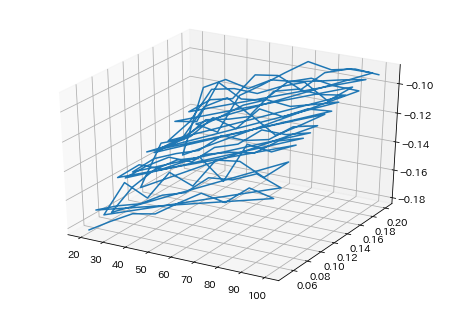

{'learning_rate': 0.19, 'n_estimators': 100}


In [255]:
from sklearn.grid_search import GridSearchCV
from mpl_toolkits.mplot3d import Axes3D
#　ホールドアウト法
Xg_train_J1, Xg_test_J1, yg_train_J1, yg_test_J1 = train_test_split(X_J1, y_J1, test_size=0.3, random_state=0)

mod1J1 =GradientBoostingRegressor(
    min_samples_split = 5, 
    min_samples_leaf = 50, 
    max_depth = 5, 
    max_features = 'sqrt', 
    subsample = 0.8)

paramJ1_1 = {'n_estimators': list(range(20, 101, 10)),
             'learning_rate': list(np.arange(0.05, 0.20, 0.01))}

# scoringを neg_mean_squared_error(負のMSE)とする
gsearch1 = GridSearchCV(estimator = mod1J1, 
                        param_grid = paramJ1_1, 
                        cv = 5, 
                        n_jobs=4, 
                        scoring = 'neg_mean_squared_error')

gsearch1.fit(Xg_train_J1, yg_train_J1)
x = []
y = []
z = []
for i in gsearch1.grid_scores_:
    x.append(i[0]['n_estimators'])
    y.append(i[0]['learning_rate'])
    z.append(i[1])
fig = plt.figure()
ax = Axes3D(fig)
ax.plot(x, y, z)
plt.show()
# test精度の平均が最も高かった組み合わせを出力
print(gsearch1.best_params_)

In [309]:
Xg_train_J1.shape

(534, 144)

In [256]:
# そのときのtest精度の平均を出力(RMSE)
(- gsearch1.best_score_) ** (1/2)

0.298537282383042

In [257]:
# ホールド・アウト法によるtest精度を出力(RMSE)
(- gsearch1.score(Xg_test_J1, yg_test_J1)) ** (1/2)

0.27801005403635193

結果n_estimators=100, learning_rate= 0.2が最適であると考えられる。この後はこの値を用いていく。<br>
### 1.2. min_samples_splitとmax_depthの調整
次にmin_samples_splitとmax_depthを調整する。

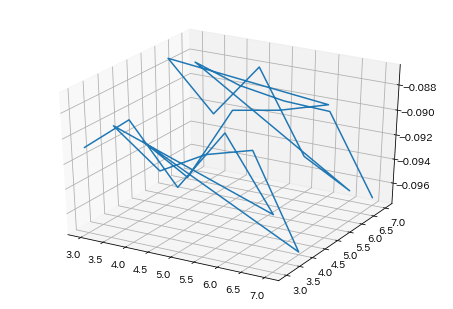

{'max_depth': 6, 'min_samples_split': 5}


In [274]:
mod2J1 =GradientBoostingRegressor(learning_rate = 0.19, n_estimators = 100, min_samples_leaf = 50, max_features = 'sqrt', subsample = 0.8)
param2J1 = {'min_samples_split': list(range(3, 8, 1)), 'max_depth': list(range(3, 8, 1))}
gsearch2 = GridSearchCV(estimator = mod2J1, param_grid = param2J1, cv = 5, n_jobs=4, scoring = 'neg_mean_squared_error')
gsearch2.fit(Xg_train_J1, yg_train_J1)
x2 = []
y2 = []
z2 = []
for i in gsearch2.grid_scores_:
    x2.append(i[0]['min_samples_split'])
    y2.append(i[0]['max_depth'])
    z2.append(i[1])
fig = plt.figure()
ax = Axes3D(fig)
ax.plot(x2, y2, z2)
plt.show()
# test精度の平均が最も高かった組み合わせを出力
print(gsearch2.best_params_)

In [272]:
#test精度の平均を出力(RMSE)
print((- gsearch2.best_score_) ** (1/2))

0.2942748176491349


In [273]:
#ホールド・アウト法によるtest精度を出力
print( (- gsearch2.score(Xg_test_J1, yg_test_J1)) ** (1/2))

0.2784377684697284


min_samples_split = 5, max_depth = 6,が最適であると考えられる。続いてmin_samples_leafの調整を行う。
### 1.3. min_samples_leafの調整

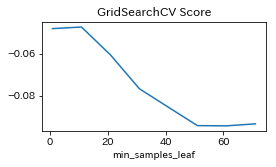

{'min_samples_leaf': 11}


In [408]:
mod3J1 =GradientBoostingRegressor(learning_rate = 0.19, n_estimators = 100, min_samples_split = 5, max_depth = 6, max_features = 'sqrt', subsample = 0.8)
param3J1 = {'min_samples_leaf' : list(range(1,72,10)) }
gsearch3 = GridSearchCV(estimator = mod3J1, param_grid = param3J1, cv = 5, n_jobs=4, scoring = 'neg_mean_squared_error')
gsearch3.fit(Xg_train_J1, yg_train_J1)
l1 = []
for i in gsearch3.grid_scores_:
    l1.append(i[1])
plt.figure(figsize=(4,2))
plt.plot(list(range(1,72,10)),  l1)
plt.title("GridSearchCV Score")
plt.xlabel("min_samples_leaf")
plt.show()
# test精度の平均が最も高かった組み合わせを出力
print(gsearch3.best_params_)

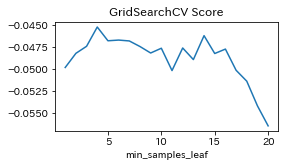

{'min_samples_leaf': 4}


In [429]:
mod3J1 =GradientBoostingRegressor(learning_rate = 0.19, n_estimators = 100, min_samples_split = 5, max_depth = 6, max_features = 'sqrt', subsample = 0.8)
param3J1 = {'min_samples_leaf' : list(range(1,21,1)) }
gsearch3 = GridSearchCV(estimator = mod3J1, param_grid = param3J1, cv = 5, n_jobs=4, scoring = 'neg_mean_squared_error')
gsearch3.fit(Xg_train_J1, yg_train_J1)
l1 = []
for i in gsearch3.grid_scores_:
    l1.append(i[1])
plt.figure(figsize=(4,2))
plt.plot(list(range(1,21,1)),  l1)
plt.title("GridSearchCV Score")
plt.xlabel("min_samples_leaf")
plt.show()
# test精度の平均が最も高かった組み合わせを出力
print(gsearch3.best_params_)

In [430]:
#test精度の平均を出力
print((- gsearch3.best_score_) ** (1/2))

0.2125592561762786


In [431]:
#ホールド・アウト法によるtest精度を出力
print(( - gsearch3.score(Xg_test_J1, yg_test_J1)) ** (1/2))

0.1994161961345939


min_samples_leafを4にする。
### 1.4. max_featuresの調整

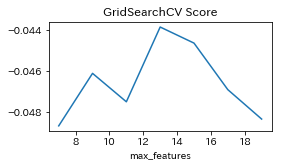

{'max_features': 13}


In [466]:
mod4J1 =GradientBoostingRegressor(learning_rate = 0.2, n_estimators = 100, min_samples_split = 5, min_samples_leaf = 4, max_depth = 6, subsample = 0.8)
param4J1 = {'max_features' : list(range(7,20,2)) }
gsearch4 = GridSearchCV(estimator = mod4J1, param_grid = param4J1, cv = 5, n_jobs=4, scoring = 'neg_mean_squared_error')
gsearch4.fit(Xg_train_J1, yg_train_J1)
l1 = []
for i in gsearch4.grid_scores_:
    l1.append(i[1])
plt.figure(figsize=(4,2))
plt.plot(list(range(7,20,2)),  l1)
plt.title("GridSearchCV Score")
plt.xlabel("max_features")
plt.show()
# test精度の平均が最も高かった組み合わせを出力
print(gsearch4.best_params_)

In [467]:
#test精度の平均を出力
print((- gsearch4.best_score_) ** (1/2))

0.20940111752331694


In [468]:
#ホールド・アウト法によるtest精度を出力
print(( - gsearch4.score(Xg_test_J1, yg_test_J1)) ** (1/2))

0.19811875953543406


ハイパーパラメータは<br>
<b>n_estimators</b> = 100<br>
<b>learning_rate </b> = 0.2<br>
<b>max_depth</b> = 6 <br>
<b>min_samples_split</b> = 5<br>
<b>min_samples_leaf</b> = 4 <br>
<b>max_features</b> = 13 <br>
<br>
続いてmodJ2について同様にハイパーパラメータ調整を行う。
n_estimatorsは20~100で調整しlearning_rateは0.05~0.2で調整する。今回はlearning_rateを0.2で固定する。他パラメータはまず以下のように固定する。<br>
<b>min_samples_split = 8</b>: 総サンプル数(831)の0.5~1%が一般的、今回はデータに偏りがあまりないので8<br>
<b>min_samples_leaf = 50</b>: 直感で選ぶ。過学習を防ぐ目的のためあまり小さな値を採用しない<br>
<b>max_depth = 5</b>: サンプル数に応じて5~8ぐらいで選択。今回はデータ数が少ないので5<br>
<b>max_features = ‘sqrt’</b>: 最初はsqrtが一般的<br>
 <b>subsample = 0.8</b>: 一般的な値
 
 ### 2.1 n_estimatorsの調整

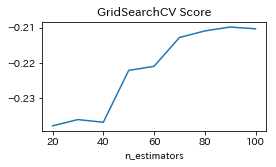

{'n_estimators': 90}


In [348]:
#　ホールドアウト法
Xg_train_J2, Xg_test_J2, yg_train_J2, yg_test_J2 = train_test_split(X_J2, y_J2, test_size=0.3, random_state=0)

mod1J2 =GradientBoostingRegressor(learning_rate = 0.2, min_samples_split = 8, min_samples_leaf = 50, max_depth = 5, max_features = 'sqrt', subsample = 0.8)
param1J2 = {'n_estimators': list(range(20, 101, 10))}
# scoringを neg_mean_squared_error(負のMSE)とする。
gsearch5 = GridSearchCV(estimator = mod1J2, param_grid = param1J2, cv = 5, n_jobs=4, scoring = 'neg_mean_squared_error')
gsearch5.fit(Xg_train_J2, yg_train_J2)
l = []
for i in gsearch5.grid_scores_:
    l.append(i[1])
plt.figure(figsize=(4,2))
plt.plot(list(range(20,101, 10)),  l)
plt.title("GridSearchCV Score")
plt.xlabel("n_estimators")
plt.show()

# test精度の平均が最も高かった組み合わせを出力
print(gsearch5.best_params_)

In [349]:
#test精度の平均を出力
print((- gsearch5.best_score_) ** (1/2))

0.4581060912401603


In [350]:
#ホールド・アウト法によるtest精度を出力
print(( - gsearch5.score(Xg_test_J2, yg_test_J2)) ** (1/2))

0.44652865950970233


In [311]:
Xg_train_J2.shape

(831, 144)

n_estimators = 90に設定します。
### 2.2. min_samples_splitとmax_depthの設定

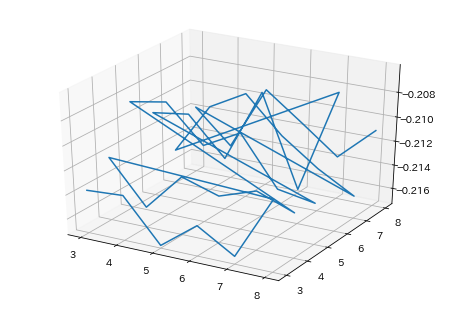

{'max_depth': 6, 'min_samples_split': 8}


In [372]:
mod2J2 =GradientBoostingRegressor(learning_rate = 0.20, n_estimators = 90, min_samples_leaf = 50, max_features = 'sqrt', subsample = 0.8)
param2J2 = {'min_samples_split': list(range(3, 9, 1)), 'max_depth': list(range(3, 9, 1))}
gsearch6 = GridSearchCV(estimator = mod2J2, param_grid = param2J2, cv = 5, n_jobs=4, scoring = 'neg_mean_squared_error')
gsearch6.fit(Xg_train_J2, yg_train_J2)
x2 = []
y2 = []
z2 = []
for i in gsearch6.grid_scores_:
    x2.append(i[0]['min_samples_split'])
    y2.append(i[0]['max_depth'])
    z2.append(i[1])
fig = plt.figure()
ax = Axes3D(fig)
ax.plot(x2, y2, z2)
plt.show()
# test精度の平均が最も高かった組み合わせを出力
print(gsearch6.best_params_)

In [364]:
#test精度の平均を出力
print((- gsearch6.best_score_) ** (1/2))

0.4562700813720185


In [373]:
#ホールド・アウト法によるtest精度を出力
print(( - gsearch6.score(Xg_test_J2, yg_test_J2)) ** (1/2))

0.44315428346144875


max_depth = 6, min_samples_split = 8に設定する。
### 2.3. min_samples_leafの調整

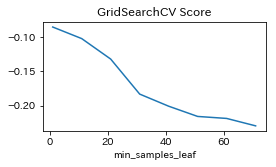

{'min_samples_leaf': 1}


In [447]:
mod3J2 =GradientBoostingRegressor(learning_rate = 0.20, n_estimators = 90, min_samples_split = 8, max_depth = 6, max_features = 'sqrt', subsample = 0.8)
param3J2 = {'min_samples_leaf' : list(range(1,72,10)) }
gsearch7 = GridSearchCV(estimator = mod3J2, param_grid = param3J2, cv = 5, n_jobs=4, scoring = 'neg_mean_squared_error')
gsearch7.fit(Xg_train_J2, yg_train_J2)
l1 = []
for i in gsearch7.grid_scores_:
    l1.append(i[1])
plt.figure(figsize=(4,2))
plt.plot(list(range(1,72,10)),  l1)
plt.title("GridSearchCV Score")
plt.xlabel("min_samples_leaf")
plt.show()
# test精度の平均が最も高かった組み合わせを出力
print(gsearch7.best_params_)

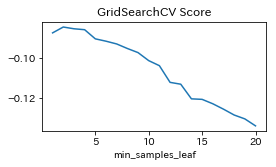

{'min_samples_leaf': 2}


In [453]:
##細かくとる
mod3J2 =GradientBoostingRegressor(learning_rate = 0.20, n_estimators = 90, min_samples_split = 8, max_depth = 6, max_features = 'sqrt', subsample = 0.8)
param3J2 = {'min_samples_leaf' : list(range(1,21,1)) }
gsearch7 = GridSearchCV(estimator = mod3J2, param_grid = param3J2, cv = 5, n_jobs=4, scoring = 'neg_mean_squared_error')
gsearch7.fit(Xg_train_J2, yg_train_J2)
l1 = []
for i in gsearch7.grid_scores_:
    l1.append(i[1])
plt.figure(figsize=(4,2))
plt.plot(list(range(1,21,1)),  l1)
plt.title("GridSearchCV Score")
plt.xlabel("min_samples_leaf")
plt.show()
# test精度の平均が最も高かった組み合わせを出力
print(gsearch7.best_params_)

In [454]:
#test精度の平均を出力
print((- gsearch7.best_score_) ** (1/2))

0.29034808298629283


In [455]:
#ホールド・アウト法によるtest精度を出力
print(( - gsearch7.score(Xg_test_J2, yg_test_J2)) ** (1/2))

0.29408762507350467


min_samples_leaf =2に設定した。
### 2.4. max_featuresの調整

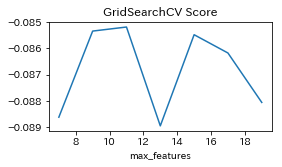

{'max_features': 11}


In [479]:
mod4J2 =GradientBoostingRegressor(learning_rate = 0.2, n_estimators = 90, min_samples_split = 8, min_samples_leaf = 2, max_depth = 6, subsample = 0.8)
param4J2 = {'max_features' : list(range(7,20,2)) }
gsearch8 = GridSearchCV(estimator = mod4J2, param_grid = param4J2, cv = 5, n_jobs=4, scoring = 'neg_mean_squared_error')
gsearch8.fit(Xg_train_J2, yg_train_J2)
l1 = []
for i in gsearch8.grid_scores_:
    l1.append(i[1])
plt.figure(figsize=(4,2))
plt.plot(list(range(7,20,2)),  l1)
plt.title("GridSearchCV Score")
plt.xlabel("max_features")
plt.show()
# test精度の平均が最も高かった組み合わせを出力
print(gsearch8.best_params_)

ハイパーパラメータは<br>
<b>n_estimators</b> = 90<br>
<b>learning_rate </b> = 0.2<br>
<b>max_depth</b> = 6 <br>
<b>min_samples_split</b> = 8<br>
<b>min_samples_leaf</b> = 2 <br>
<b>max_features</b> = 11 <br>
<br>

In [480]:
mod2_J1 = GradientBoostingRegressor(learning_rate = 0.2, n_estimators = 100, min_samples_split = 5, min_samples_leaf = 4, max_depth = 6, subsample = 0.8, max_features = 13)
mod2_J2 = GradientBoostingRegressor(learning_rate = 0.2, n_estimators = 90, min_samples_split = 8, min_samples_leaf = 2, max_depth = 6, subsample = 0.8, max_features = 11)
mod2_J1.fit(X_train_J1, y_train_J1)
mod2_J2.fit(X_train_J2, y_train_J2)
X_test_J1['logy'] = mod2_J1.predict(X_test_J1.values)
X_test_J2['logy'] = mod2_J2.predict(X_test_J2.values)

In [481]:
X_test_J1['y'] = np.exp(X_test_J1['logy'])
X_test_J2['y'] = np.exp(X_test_J2['logy'])
df_test = pd.concat([X_test_J1[['y']], X_test_J2[['y']]]).sort_index()
df_test.to_csv('../submit2.csv', header=None)

In [588]:
XtrainJ1, XtestJ1, ytrainJ1, ytestJ1 = train_test_split(X_J2, y_J2, test_size=0.3, random_state=0)
XtrainJ2, XtestJ2, ytrainJ2, ytestJ2 = train_test_split(X_J2, y_J2, test_size=0.3, random_state=0)

import optuna
def gboostJ1(trial):
    #lr = trial.suggest_uniform("lr", 0.05, 0.20) #learning_rate
    ne = trial.suggest_int("ne", 20, 100) #n_estimator
    mss = trial.suggest_int("mss", 3, 9)
    md = trial.suggest_int("md", 3, 9)
    msl = trial.suggest_int("msl", 1, 30)
    mf = trial.suggest_int("mf", 7, 20)
    gbr1 = GradientBoostingRegressor(learning_rate = 0.20, n_estimators = ne, min_samples_split = mss, min_samples_leaf = msl, max_depth = md, subsample = 0.8, max_features = mf)
    gbr1.fit(XtrainJ1, ytrainJ1)
    #train1_rmse = (mse(ytrainJ1, gbr1.predict(XtrainJ1)) ** (1/2))
    val1_rmse = (mse(ytestJ1, gbr1.predict(XtestJ1)) ** (1/2))
    return val1_rmse

In [589]:
def gboostJ2(trial):   
    #lr = trial.suggest_discrete_uniform("lr", 0.05, 0.20, 0.01) #learning_rate
    ne = trial.suggest_int("ne", 20, 10) #n_estimator
    mss = trial.suggest_int("mss", 3, 9)
    md = trial.suggest_int("md", 3, 9)
    msl = trial.suggest_int("msl", 1, 30)
    mf = trial.suggest_int("mf", 7, 20)
    gbr2 = GradientBoostingRegressor(learning_rate = 0.2, n_estimators = ne, min_samples_split = mss, min_samples_leaf = msl, max_depth = md, subsample = 0.8, max_features = mf)
    #train2_rmse = (mse(ytrainJ2, gbr2.predict(XtrainJ2)) ** (1/2))
    gbr2.fit(XtrainJ2, ytrainJ2)
    val2_rmse = (mse(ytestJ2, gbr2.predict(XtestJ2)) ** (1/2))
    return val2_rmse

In [1]:
study1 = optuna.create_study()
study1.optimize(gboostJ1, n_trials = 500)

NameError: name 'optuna' is not defined

In [591]:
study1.best_params

{'ne': 59, 'mss': 8, 'md': 8, 'msl': 5, 'mf': 14}

In [592]:
study1.best_value

0.28833922971766573

In [ ]:
study2 = optuna.create_study()
study2.optimize(gboostJ2, n_trials = 500)

In [ ]:
study2.best_params

In [ ]:
study2.best_value

In [579]:
X_test_J1=X_test_J1.drop("logy", axis=1)
X_test_J2=X_test_J2.drop("logy", axis=1)
X_test_J1=X_test_J1.drop("y", axis=1)
X_test_J2=X_test_J2.drop("y", axis=1)

In [580]:
mod100_J1 = GradientBoostingRegressor(learning_rate = 0.08826373824387262, n_estimators = 96, min_samples_split = 5, min_samples_leaf = 4, max_depth = 9, subsample = 0.8, max_features = 15)
mod100_J2 = GradientBoostingRegressor(learning_rate = 0.11, n_estimators = 78, min_samples_split = 9, min_samples_leaf = 5, max_depth = 10, subsample = 0.8, max_features = 22)
mod100_J1.fit(X_train_J1, y_train_J1)
mod100_J2.fit(X_train_J2, y_train_J2)
X_test_J1['logy'] = mod100_J1.predict(X_test_J1.values)
X_test_J2['logy'] = mod100_J2.predict(X_test_J2.values)
X_test_J1['y'] = np.exp(X_test_J1['logy'])
X_test_J2['y'] = np.exp(X_test_J2['logy'])
df_test = pd.concat([X_test_J1[['y']], X_test_J2[['y']]]).sort_index()
df_test.to_csv('../submit100.csv', header=None)